# Darknet Detection
> PASCAL VOC2007

In [ ]:
from minai import *

import torch
import torch.nn as nn
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.v2.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2

import fastcore.all as fc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.utils import L

from IPython.display import display, Image

from pilus_project.core import *
from pilus_project.darknet import *

## Data 

### Data loading

Let's take a look at VOC2007.

In [ ]:
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#3) [Path('/home/kappa/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/kappa/data/VOCdevkit'),Path('/home/kappa/data/pili')]

In [ ]:
ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)
ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data

### Checking out data

What's in the data?

In [ ]:
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

In [ ]:
def show_voc_sample(ds, idx, figsize=(12,10)):
    img, target = ds[idx]
    objects = target['annotation']['object']
    img_array = np.array(img)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_array)
    width = int(target['annotation']['size']['width'])
    height = int(target['annotation']['size']['height'])
    for obj in objects:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-5, obj['name'], 
                bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')
    ax.set_title(f"Image {idx}: {', '.join([obj['name'] for obj in objects])}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Image size: {width}x{height}")
    print(f"Number of objects: {len(objects)}")
    for i, obj in enumerate(objects):
        print(f"Object {i+1}: {obj['name']}, Difficult: {obj['difficult']}, Truncated: {obj['truncated']}")

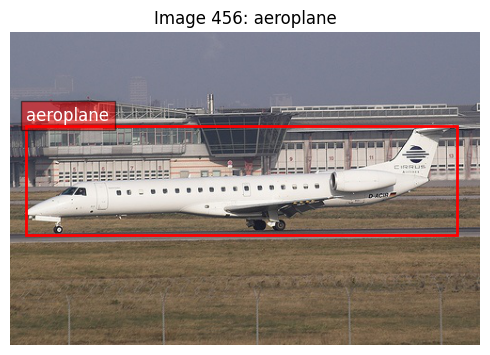

Image size: 500x333
Number of objects: 1
Object 1: aeroplane, Difficult: 0, Truncated: 0


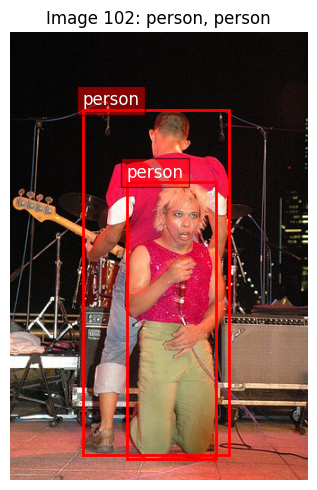

Image size: 332x500
Number of objects: 2
Object 1: person, Difficult: 0, Truncated: 0
Object 2: person, Difficult: 0, Truncated: 0


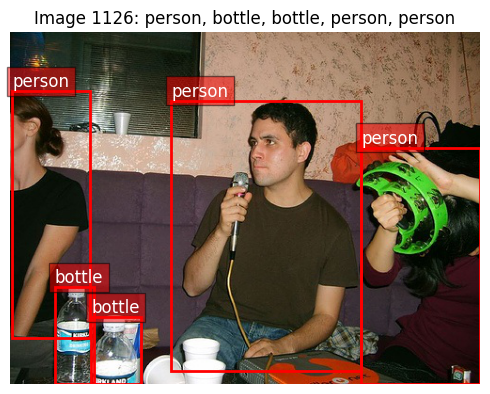

Image size: 500x375
Number of objects: 5
Object 1: person, Difficult: 0, Truncated: 1
Object 2: bottle, Difficult: 0, Truncated: 1
Object 3: bottle, Difficult: 0, Truncated: 1
Object 4: person, Difficult: 0, Truncated: 1
Object 5: person, Difficult: 0, Truncated: 1


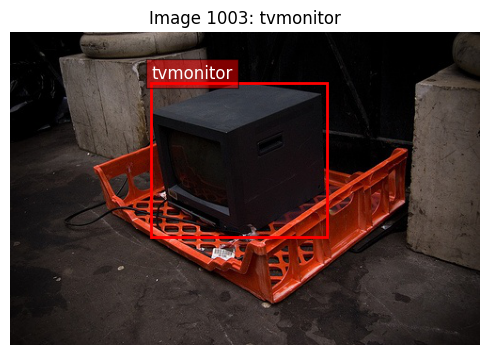

Image size: 500x333
Number of objects: 1
Object 1: tvmonitor, Difficult: 0, Truncated: 0


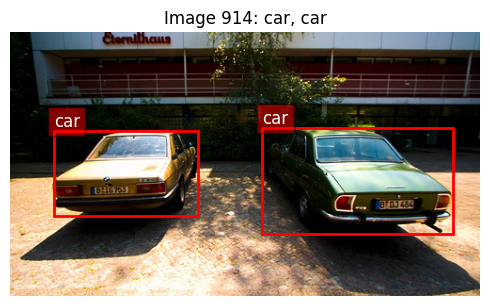

Image size: 500x281
Number of objects: 2
Object 1: car, Difficult: 0, Truncated: 0
Object 2: car, Difficult: 0, Truncated: 0


In [ ]:
set_seed(42)
import random
random_indices = random.sample(range(len(ds)), 5)
for idx in random_indices:
    show_voc_sample(ds, idx, figsize=(5,5))

In [ ]:
def get_class_distribution(ds):
    "Get distribution of classes in the dataset"
    counts = {}
    for i in range(len(ds)):
        img, target = ds[i]
        for obj in target['annotation']['object']:
            cls = obj['name']
            counts[cls] = counts.get(cls, 0) + 1
    return pd.Series(counts).sort_values(ascending=False)

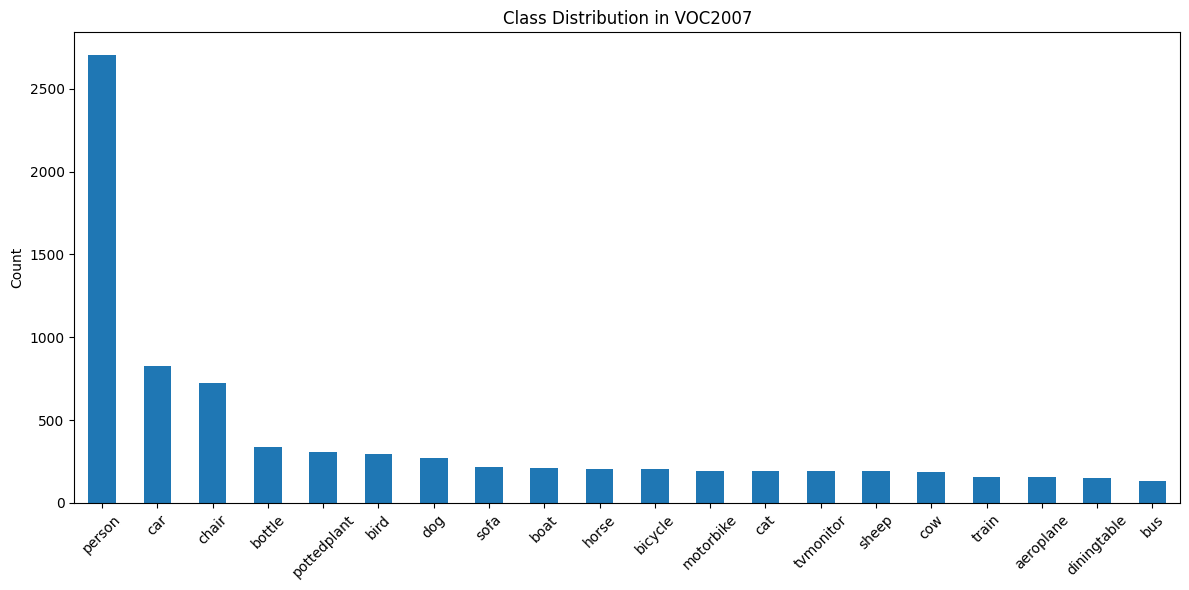

In [ ]:
class_dist = get_class_distribution(ds)
plt.figure(figsize=(12, 6))
class_dist.plot(kind='bar')
plt.title('Class Distribution in VOC2007')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
def get_image_sizes(ds, n=100):
    "Get distribution of image sizes in the dataset"
    sizes = []
    for i in range(min(n, len(ds))):
        img, _ = ds[i]
        sizes.append(img.size)
    return pd.DataFrame(sizes, columns=['width', 'height'])

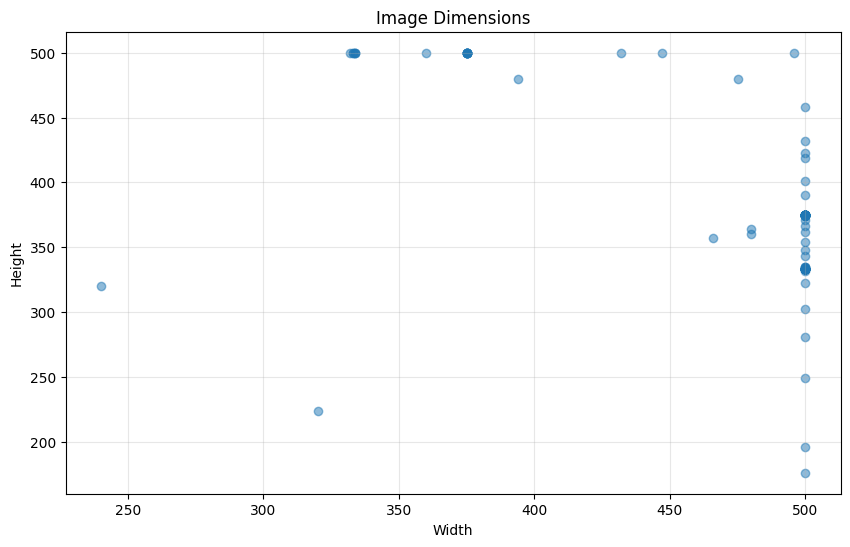

In [ ]:
sizes = get_image_sizes(ds)
plt.figure(figsize=(10, 6))
plt.scatter(sizes['width'], sizes['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True, alpha=0.3)

In [ ]:
def show_class_examples(ds, class_name, n=4):
    "Show examples of a specific class"
    examples = []
    for i in range(len(ds)):
        img, target = ds[i]
        if any(obj['name'] == class_name for obj in target['annotation']['object']):
            examples.append((img, target))
            if len(examples) >= n: break
    
    fig, axes = subplots(1, n, figsize=(n*4, 4))
    for i, (img, target) in enumerate(examples):
        axes[i].imshow(img)
        axes[i].set_title(f"Example {i+1}")
        axes[i].axis('off')
        
        for obj in target['annotation']['object']:
            if obj['name'] == class_name:
                bbox = obj['bndbox']
                x1, y1 = int(bbox['xmin']), int(bbox['ymin'])
                x2, y2 = int(bbox['xmax']), int(bbox['ymax'])
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   fill=False, edgecolor='green', linewidth=2)
                axes[i].add_patch(rect)
    
    plt.suptitle(f"Examples of '{class_name}'")
    plt.tight_layout()
    return fig

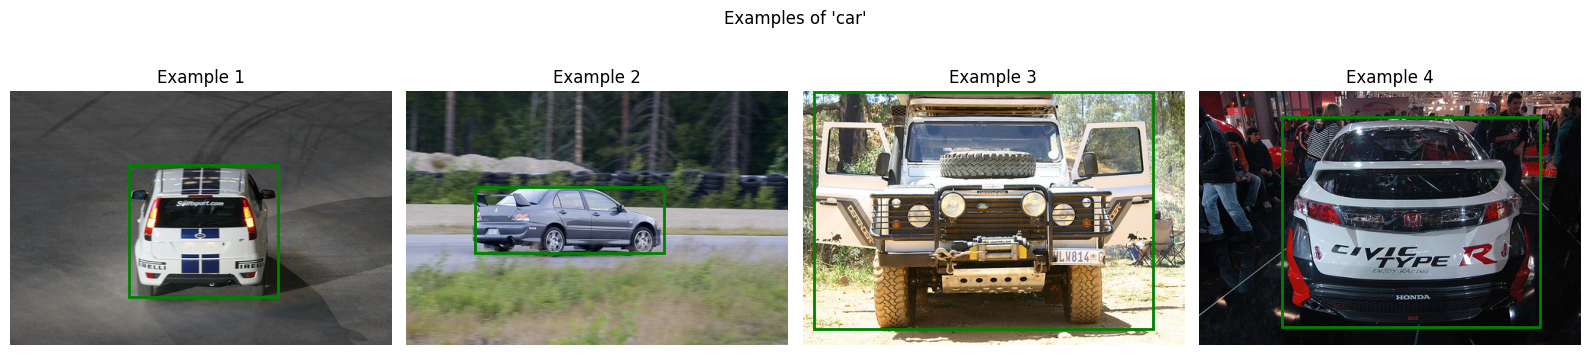

In [ ]:
show_class_examples(ds, 'car');

Text(0, 0.5, 'Number of Images')

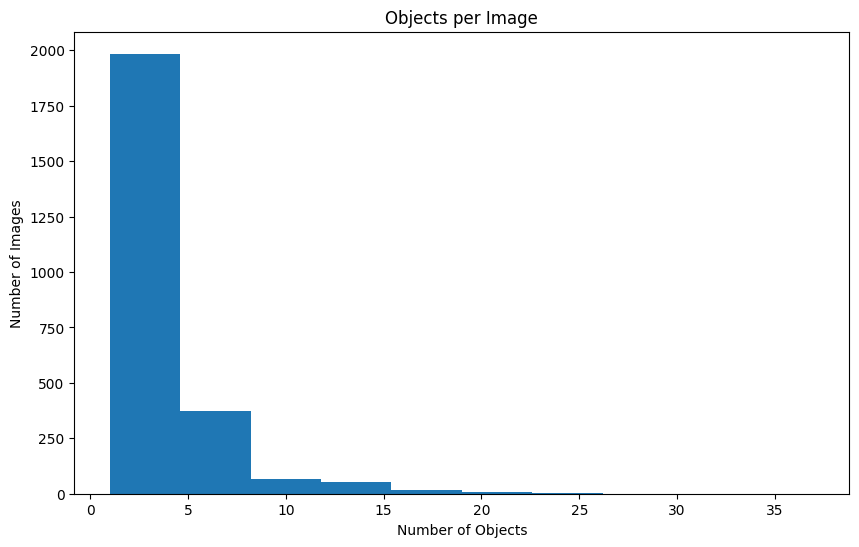

In [ ]:
objects_per_image = [len(ds[i][1]['annotation']['object']) for i in range(len(ds))]
plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=10)
plt.title('Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')

In [ ]:
def calculate_dataset_stats(dataloader, max_images=None):
    """Calculate mean and std of a dataset using a dataloader.
    
    Args:
        dataloader: DataLoader instance
        max_images: Maximum number of images to use (None = use all)
    
    Returns:
        mean and std per channel
    """
    # Create running sums
    channel_sum = torch.zeros(3)
    channel_sum_squared = torch.zeros(3)
    num_pixels = 0
    
    # Use tqdm for progress bar
    from tqdm.auto import tqdm
    
    for i, (images, _) in enumerate(tqdm(dataloader)):
        if max_images is not None and i*dataloader.batch_size >= max_images:
            break
        
        # Make sure images are in the right format
        if not isinstance(images, torch.Tensor):
            continue
            
        # Reshape: [B, C, H, W] -> [B, C, H*W]
        b, c, h, w = images.shape
        images = images.reshape(b, c, -1)
        
        # Update sums
        channel_sum += images.sum(dim=[0, 2])
        channel_sum_squared += (images**2).sum(dim=[0, 2])
        num_pixels += b * h * w
    
    # Calculate mean and std
    mean = channel_sum / num_pixels
    std = torch.sqrt((channel_sum_squared / num_pixels) - (mean**2))
    
    return mean, std

# Create a simple dataloader without normalization for calculation
def get_stats_dataloader(data_path, bs=32, year='2007'):
    """Create a dataloader for calculating dataset statistics"""
    # Basic transforms without normalization
    basic_tfms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)  # Scales to [0, 1]
    ])
    
    # Create dataset with basic transforms
    ds = datasets.VOCDetection(
        root=data_path, 
        year=year, 
        image_set='train', 
        download=False,
        transform=basic_tfms
    )
    
    # Create a dataloader with a simple collate function that only returns images
    def simple_collate(batch): return torch.stack([item[0] for item in batch]), None
    
    return DataLoader(ds, batch_size=bs, shuffle=False, 
                     collate_fn=simple_collate, num_workers=4)

In [ ]:
stats_dl = get_stats_dataloader(data_path, bs=32)

mean, std = calculate_dataset_stats(stats_dl, max_images=2500)

print(f"Dataset mean: {mean.tolist()}")
print(f"Dataset std: {std.tolist()}")

  0%|          | 0/79 [00:00<?, ?it/s]

Dataset mean: [0.45178917050361633, 0.4230521619319916, 0.3900362253189087]
Dataset std: [0.267049103975296, 0.26186153292655945, 0.27329710125923157]


### Dataset

In [ ]:
def create_voc_datasets(data_path, train_tfms=None, valid_tfms=None, year='2007'):
    "Create training and validation datasets for VOC"
    if train_tfms is None:
        train_tfms = v2.Compose([
            v2.RandomResizedCrop(224),
            v2.RandomHorizontalFlip(),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    if valid_tfms is None:
        valid_tfms = v2.Compose([
            v2.Resize(256),
            v2.CenterCrop(224),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    train_ds = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False,
                                    transform=train_tfms)
    valid_ds = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False,
                                   transform=valid_tfms)
    return train_ds, valid_ds

def voc_collate_fn(batch):
    "Custom collate function for VOC dataset that handles images and targets"
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        objects = target['annotation']['object']
        label = torch.zeros(len(VOC_CLASSES))
        for obj in objects:
            class_idx = VOC_CLASSES.index(obj['name'])
            label[class_idx] = 1
        
        targets.append(label)
    
    images = torch.stack(images)
    targets = torch.stack(targets)
    return images, targets

def get_voc_dls(data_path, bs=16, year='2007', num_workers=4):
    "Create dataloaders for VOC dataset"
    train_ds, valid_ds = create_voc_datasets(data_path, year=year)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, 
                         collate_fn=voc_collate_fn, num_workers=num_workers)
    valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False, 
                         collate_fn=voc_collate_fn, num_workers=num_workers)
    return DataLoaders(train_dl, valid_dl)

In [ ]:
class VOCClassificationDataset(Dataset):
    "Dataset for VOC classification (multi-label)"
    def __init__(self, voc_ds): self.voc_ds = voc_ds
        
    def __len__(self): return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        
        objects = target['annotation']['object']
        label = torch.zeros(len(VOC_CLASSES))
        for obj in objects:
            class_idx = VOC_CLASSES.index(obj['name'])
            label[class_idx] = 1
        
        return img, label

In [ ]:
def create_voc_tfm_datasets(data_path, year='2007'):
    "Create TfmDataset for VOC"
    train_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False)
    valid_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False)
    
    train_ds = VOCClassificationDataset(train_ds_raw)
    valid_ds = VOCClassificationDataset(valid_ds_raw)
    
    train_tfms = v2.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    valid_tfms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_tfm_ds = TfmDataset(train_ds.voc_ds, train_ds.voc_ds, tfm_x=train_tfms)
    valid_tfm_ds = TfmDataset(valid_ds.voc_ds, valid_ds.voc_ds, tfm_x=valid_tfms)
    
    return train_tfm_ds, valid_tfm_ds

Denormalize image before display

In [ ]:
from torch import tensor

xmean,xstd = (tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225]))
xmean.shape

torch.Size([3])

In [ ]:
xmean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

In [ ]:
def get_voc_dls_minai(data_path, bs=16, year='2007'):
    "Create dataloaders using minai's get_dls function"
    train_ds, valid_ds = create_voc_tfm_datasets(data_path, year=year)
    return get_dls(train_ds, valid_ds, bs=bs, collate_fn=voc_collate_fn)

In [ ]:
trn_ds, vld_ds = create_voc_tfm_datasets(data_path)
trn_ds[0]

((Image([[[-1.0733, -1.0733, -1.0219,  ..., -0.9020, -0.9192, -0.8849],
          [-1.0562, -1.0390, -1.0390,  ..., -0.8507, -0.8678, -0.8678],
          [-1.0562, -1.0219, -1.0390,  ..., -0.8335, -0.8335, -0.8507],
          ...,
          [-0.7308, -0.7822, -0.7650,  ...,  0.1083,  0.1083,  0.1597],
          [-0.7479, -0.7308, -0.7822,  ...,  0.1254,  0.1254,  0.1254],
          [-0.7650, -0.8164, -0.8507,  ...,  0.0912,  0.0398, -0.0458]],
  
         [[-0.9678, -0.9678, -0.9153,  ..., -0.7927, -0.8102, -0.7752],
          [-0.9503, -0.9328, -0.9328,  ..., -0.7402, -0.7577, -0.7577],
          [-0.9503, -0.9153, -0.9328,  ..., -0.7227, -0.7227, -0.7402],
          ...,
          [-0.6527, -0.7052, -0.6702,  ...,  0.1527,  0.1527,  0.2052],
          [-0.6527, -0.6352, -0.6702,  ...,  0.1877,  0.1877,  0.1877],
          [-0.6527, -0.7052, -0.7402,  ...,  0.1702,  0.1176,  0.0301]],
  
         [[-0.7413, -0.7413, -0.6890,  ..., -0.5670, -0.5844, -0.5495],
          [-0.7238, -0.706

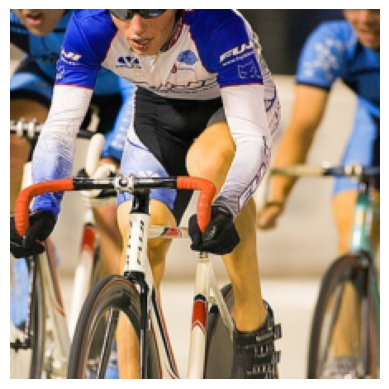

In [ ]:
show_image(denorm(trn_ds[2][0][0]));

### DataLoader

Batch shape: torch.Size([16, 3, 224, 224]), Labels shape: torch.Size([16, 20])
Average labels per image: 1.56
Most common classes: ['person', 'car', 'horse', 'diningtable', 'tvmonitor']


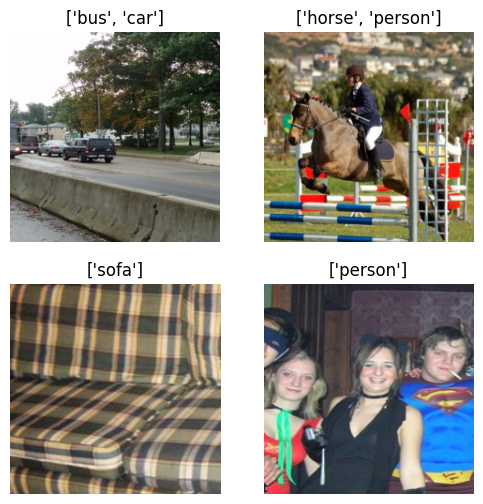

In [ ]:
dls = get_voc_dls(data_path, bs=16)

# dls_minai = get_voc_dls_minai(data_path, bs=16)

xb, yb = next(iter(dls.train))
# xb, yb = next(iter(dls_minai[0]))
print(f"Batch shape: {xb.shape}, Labels shape: {yb.shape}")

print(f"Average labels per image: {yb.sum(dim=1).mean().item():.2f}")
print(f"Most common classes: {[VOC_CLASSES[i] for i in yb.sum(dim=0).argsort(descending=True)[:5]]}")

idxs = torch.randint(0, len(xb), (4,))
show_images(
    [TF.to_pil_image(denorm(img)) for img in xb[idxs]], 
    titles=[[VOC_CLASSES[i] for i in torch.where(lbl == 1)[0]] for lbl in yb[idxs]]
)

## Training Classification

In [ ]:
import torch.nn.functional as F

In [ ]:
def get_classification_model(num_classes=len(VOC_CLASSES)):
    "Create a multi-label classification model based on darknet19"
    backbone = get_darknet19()
    model = nn.Sequential(
        backbone,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

def multi_label_loss(preds, targets):
    return F.binary_cross_entropy_with_logits(preds, targets)

model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-3, 
                   cbs=[TrainCB(), DeviceCB(), ProgressCB(), MetricsCB()])

In [ ]:
learn.summary()

Tot params: 20359636; MFLOPS: 970.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(16, 3, 224, 224)|(16, 1024, 7, 7)|19824576|970.4|
|AdaptiveAvgPool2d|(16, 1024, 7, 7)|(16, 1024, 1, 1)|0|0.0|
|Flatten|(16, 1024, 1, 1)|(16, 1024)|0|0.0|
|Linear|(16, 1024)|(16, 512)|524800|0.5|
|ReLU|(16, 512)|(16, 512)|0|0.0|
|Dropout|(16, 512)|(16, 512)|0|0.0|
|Linear|(16, 512)|(16, 20)|10260|0.0|


In [ ]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, denorm=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    xb,yb = to_cpu(self.batch)
    feat = fc.nested_attr(self.dls, 'train.dataset.features')
    denorm = denorm if denorm else fc.noop
    if feat is None: titles = np.array(to_cpu(yb))     # when fitting, yb is in GPU
    else:
        names = feat['label'].names
        titles = [names[i] for i in yb]
    show_images(denorm(xb[:max_n]), titles=titles[:max_n], **kwargs)

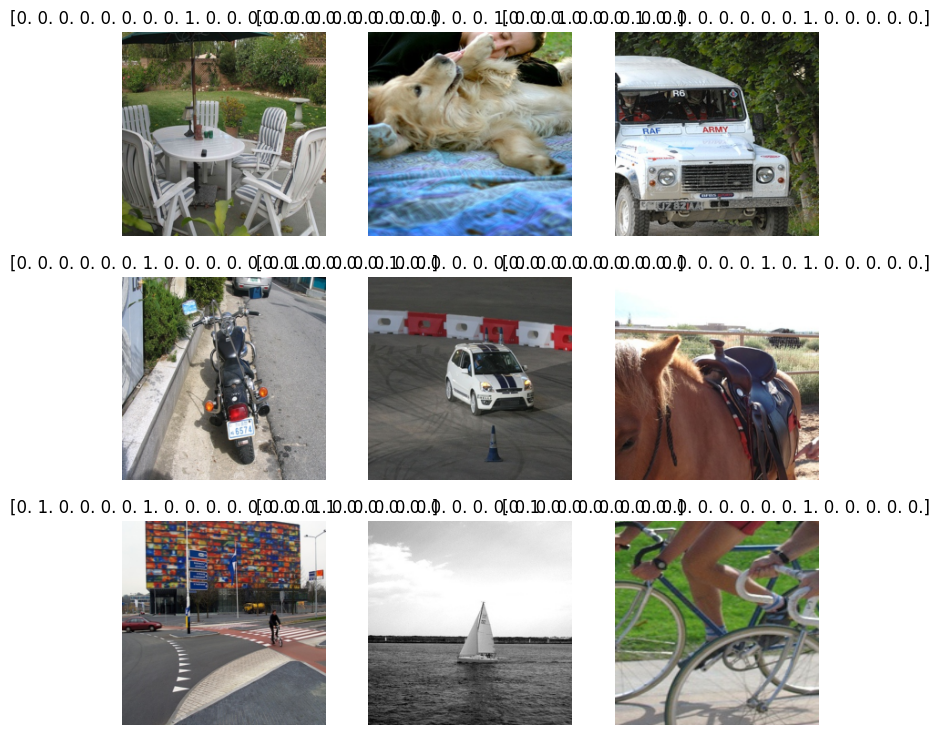

In [ ]:
learn.show_image_batch(denorm=denorm)

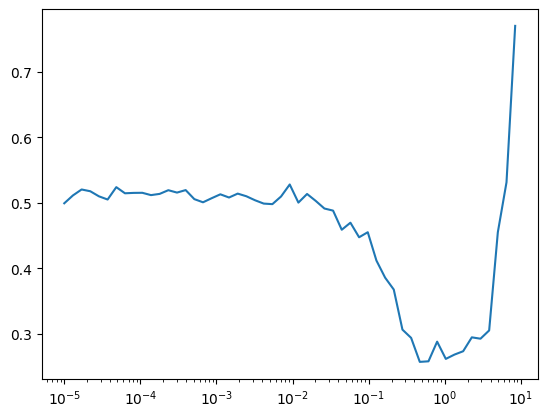

In [ ]:
learn.lr_find()

In [ ]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-2, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB()])
learn.fit(3)

In [ ]:
class TopKAccuracy(Callback):
    def __init__(self, k_values=[1, 5], class_names=VOC_CLASSES):
        """
        Implements Top-K accuracy for multi-label classification
        
        Args:
            k_values: List of k values to compute (e.g., [1, 5] for top-1 and top-5)
            class_names: List of class names
        """
        self.k_values = sorted(k_values)
        self.max_k = max(k_values)
        self.class_names = class_names
        
    def before_fit(self, learn):
        self.learn = learn
        
    def before_epoch(self, learn):
        # Initialize counters for each k
        self.correct = {k: 0 for k in self.k_values}
        self.total = 0
        
    def after_batch(self, learn):
        # Get predictions and targets
        logits = to_cpu(learn.preds)
        targets = to_cpu(learn.batch[1])
        batch_size = targets.size(0)
        
        # For each image in the batch
        for i in range(batch_size):
            # Get ground truth classes for this image
            true_classes = torch.where(targets[i] == 1)[0]
            if len(true_classes) == 0:
                continue  # Skip images with no labels
                
            # Get top-k predicted classes
            _, top_indices = torch.topk(logits[i], min(self.max_k, len(self.class_names)))
            
            # Check if any true class is in top-k predictions
            for k in self.k_values:
                top_k_indices = top_indices[:k]
                # For multi-label: if any true class is in top-k predictions, count as correct
                if any(cls in top_k_indices for cls in true_classes):
                    self.correct[k] += 1
            
            self.total += 1
        
    def after_epoch(self, learn):
        phase = 'train' if learn.training else 'valid'
        for k in self.k_values:
            accuracy = self.correct[k] / self.total if self.total > 0 else 0
            print(f"{phase} top-{k} accuracy: {accuracy:.4f}")

# Alternative implementation that considers a prediction correct only if 
# all true classes are in the top-k predictions
class StrictTopKAccuracy(Callback):
    def __init__(self, k_values=[1, 5], class_names=VOC_CLASSES):
        self.k_values = sorted(k_values)
        self.max_k = max(k_values)
        self.class_names = class_names
        
    def before_fit(self, learn):
        self.learn = learn
        
    def before_epoch(self, learn):
        self.correct = {k: 0 for k in self.k_values}
        self.total = 0
        
    def after_batch(self, learn):
        logits = to_cpu(learn.preds)
        targets = to_cpu(learn.batch[1])
        batch_size = targets.size(0)
        
        for i in range(batch_size):
            true_classes = torch.where(targets[i] == 1)[0]
            if len(true_classes) == 0:
                continue
                
            _, top_indices = torch.topk(logits[i], min(self.max_k, len(self.class_names)))
            
            for k in self.k_values:
                if k < len(true_classes):
                    continue  # Can't fit all true classes in top-k if k < number of true classes
                    
                top_k_indices = set(top_indices[:k].tolist())
                true_classes_set = set(true_classes.tolist())
                
                # Strict version: all true classes must be in top-k predictions
                if true_classes_set.issubset(top_k_indices):
                    self.correct[k] += 1
            
            self.total += 1
        
    def after_epoch(self, learn):
        phase = 'train' if learn.training else 'valid'
        for k in self.k_values:
            accuracy = self.correct[k] / self.total if self.total > 0 else 0
            print(f"{phase} strict top-{k} accuracy: {accuracy:.4f}")

In [ ]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-3, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB(), 
                        TopKAccuracy(k_values=[1, 5])])

In [ ]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-3, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB(), 
                        TopKAccuracy(k_values=[1, 5]), 
                        StrictTopKAccuracy(k_values=[1, 5])])

In [ ]:
learn.fit(5)

KeyboardInterrupt: 